**CS109A Final Project**<br/>
**Group 12**<br/>
**EDA Page**<br/>

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load in data
df = pd.read_csv('total_info.csv', encoding = 'latin-1')

In [3]:
# Clean Variables
del df['Unnamed: 0']
df['artist_popularity'] = pd.to_numeric(df['artist_popularity'], errors = 'coerce')
df['artist_followers'] = pd.to_numeric(df['artist_followers'], errors = 'coerce')

In [4]:
# Create pop indicator variable array
pop_ind = []
rap_ind = []
rock_ind = []
hip_hop_ind = []

for idx, row in enumerate(df['artist_genres'].values):
    if 'pop' in row:
        pop_ind.append(1)
        rap_ind.append(0)
        rock_ind.append(0)
        hip_hop_ind.append(0)
    elif 'rap' in row:
        rap_ind.append(1)
        pop_ind.append(0)
        rock_ind.append(0)
        hip_hop_ind.append(0)
    elif 'rock' in row:
        rock_ind.append(1)
        rap_ind.append(0)
        pop_ind.append(0)
        hip_hop_ind.append(0)
    elif 'hip' in row:
        rap_ind.append(0)
        pop_ind.append(0)
        rock_ind.append(0)
        hip_hop_ind.append(1)
    else:
        pop_ind.append(0)
        rap_ind.append(0)
        rock_ind.append(0)
        hip_hop_ind.append(0)
        
# Append array to dataframe
df['pop_ind'] = pop_ind
df['rap_ind'] = rap_ind
df['rock_ind'] = rock_ind
df['hip_hop_ind'] = hip_hop_ind

In [5]:
# Artist Popularity 75% is a 75, use for indicator 
df['artist_popularity'].describe()
df['popular_artist_ind'] = (df['artist_popularity'] >= 75)*1
df.columns

Index(['playlist_id', 'playlist_name', 'followers', 'song_name',
       'number_of_artists', 'artist_name', 'artist_id', 'popularity',
       'track_number', 'explicit', 'duration_ms', 'available_markets',
       'delete', 'artist_popularity', 'artist_followers', 'artist_genres',
       'pop_ind', 'rap_ind', 'rock_ind', 'hip_hop_ind', 'popular_artist_ind'],
      dtype='object')

In [6]:
# Sum Up the 100 tracks of info (or less) for each playlist
unique_plists = df['playlist_id'].unique()
columns = ['playlist','name','followers','num_songs','av_song_pop','pct_explicit','avg_dur','av_artist_followers', 'pop_pct', 'rap_pct', 'rock_pct', 'popular_artist_pct']
eda_frame = pd.DataFrame(index=range(0,len(unique_plists)), columns=columns)

for idx,plist in enumerate(unique_plists):
    eda_frame.loc[idx]['playlist'] = plist
    eda_frame.loc[idx]['name'] = df.loc[df['playlist_id'] == plist]['playlist_name']
    eda_frame.loc[idx]['followers'] = np.mean(df.loc[df['playlist_id'] == plist]['followers'])
    eda_frame.loc[idx]['num_songs'] = len(df.loc[df['playlist_id'] == plist])
    eda_frame.loc[idx]['av_song_pop'] = np.mean(df.loc[df['playlist_id'] == plist]['popularity'])
    eda_frame.loc[idx]['pct_explicit'] = np.mean(df.loc[df['playlist_id'] == plist]['explicit'])
    eda_frame.loc[idx]['avg_dur'] = np.mean(df.loc[df['playlist_id'] == plist]['duration_ms'])
    eda_frame.loc[idx]['av_artist_followers'] = np.mean(df.loc[df['playlist_id'] == plist]['artist_followers'])
    eda_frame.loc[idx]['pop_pct'] = np.mean(df.loc[df['playlist_id'] == plist]['pop_ind'])
    eda_frame.loc[idx]['rap_pct'] = np.mean(df.loc[df['playlist_id'] == plist]['rap_ind'])
    eda_frame.loc[idx]['rock_pct'] = np.mean(df.loc[df['playlist_id'] == plist]['rock_ind'])
    eda_frame.loc[idx]['hip_hop_pct'] = np.mean(df.loc[df['playlist_id'] == plist]['hip_hop_ind'])
    eda_frame.loc[idx]['avg_num_artists'] = np.mean(df.loc[df['playlist_id'] == plist]['number_of_artists'])
    eda_frame.loc[idx]['popular_artist_pct'] = np.mean(df.loc[df['playlist_id'] == plist]['popular_artist_ind'])

In [7]:
eda_frame.head()

,playlist,name,followers,num_songs,av_song_pop,pct_explicit,avg_dur,av_artist_followers,pop_pct,rap_pct,rock_pct,popular_artist_pct
0,37i9dQZF1DXcBWIGoYBM5M,0 Today's Top Hits 47 Today's Top H...,1.81239e+07,50,82.38,0.34,208121,2.75535e+06,0.8,0.06,0,1
1,37i9dQZF1DWXDAhqlN7e6W,1 This Is: Max Martin 125 This Is:...,15685,44,55.5227,0.113636,220925,3.99045e+06,0.977273,0,0.0227273,0.75
2,37i9dQZF1DX7Q7o98uPeg1,2 Funkst 2500 Funkst 2569 Funks...,397098,100,32.87,0.09,241358,319005,0.12,0.42,0.02,0.08
3,37i9dQZF1DX3LyU0mhfqgP,3 Out Now 48 Out Now 267 Out...,439685,55,71.7273,0.181818,207392,1.02241e+06,0.654545,0,0,0.6
4,37i9dQZF1DX35oM5SPECmN,4 HIIT Workout 129 HIIT Workout 48...,712771,50,59.06,0.12,223608,3.32207e+06,0.9,0,0.04,0.62


In [8]:
# for i,val in enumerate(eda_frame['followers'].values):
#     if eda_frame['followers'][i] != 0:
#         eda_frame['log_followers'][i] = np.log(eda_frame['followers'][i])
#     else:
#         pass
    
# for i,val in enumerate(eda_frame['av_artist_followers'].values):
#     if eda_frame['av_artist_followers'][i] != 0:
#         eda_frame['log_artist_follow'][i] = np.log(eda_frame['av_artist_followers'][i])
#     else:
#         pass

eda_frame['log_followers'] = np.log(eda_frame['followers'].astype(float))
eda_frame['log_artist_follow'] = np.log(eda_frame['av_artist_followers'].astype(float))
eda_frame = eda_frame.dropna(0)
eda_frame = eda_frame.replace([np.inf, -np.inf], 0)

In [9]:
plt.hist(log_followers);
plt.title('Follower Distribution')
plt.xlabel("Log # of followers");
plt.ylabel("Frequency")
sns.despine(bottom=True, left=True)
plt.grid(axis = 'x', color ='white', linestyle='-')
ax = plt.gca()
ax.tick_params(axis='both', which='both',length=0);

NameError: name 'log_followers' is not defined

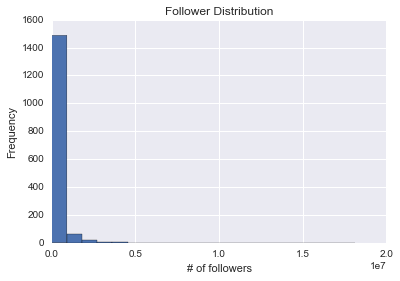

In [10]:
plt.hist(eda_frame['followers'], bins = 20)
plt.title('Follower Distribution')
plt.xlabel("# of followers");
plt.ylabel("Frequency")
sns.despine(bottom=True, left=True)
plt.grid(axis = 'x', color ='white', linestyle='-')
ax = plt.gca()
ax.tick_params(axis='both', which='both',length=0);

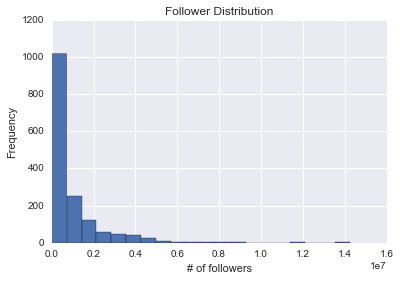

In [11]:
plt.hist(eda_frame['av_artist_followers'], bins = 20)
plt.title('Follower Distribution')
plt.xlabel("# of followers");
plt.ylabel("Frequency")
sns.despine(bottom=True, left=True)
plt.grid(axis = 'x', color ='white', linestyle='-')
ax = plt.gca()
ax.tick_params(axis='both', which='both',length=0);

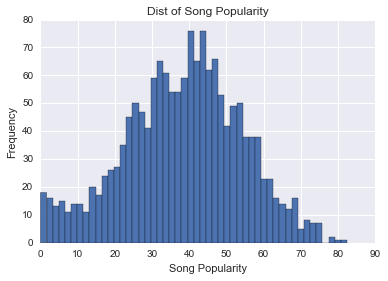

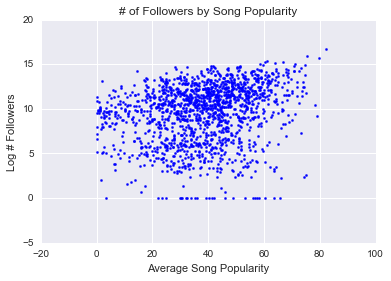

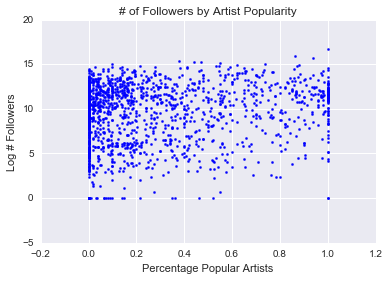

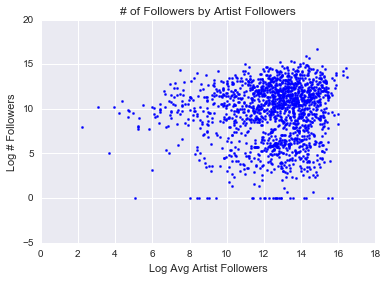

In [12]:
# average song pop vs number of followers

eda_sorted = eda_frame.sort_values(by='log_followers')
log_followers = list(eda_sorted['log_followers'])
followers = list(eda_sorted['followers'])
pop = list(eda_sorted['av_song_pop'])

plt.figure()
plt.hist(pop, bins = 50)
plt.xlabel("Song Popularity");
plt.ylabel("Frequency")
plt.title("Dist of Song Popularity")
sns.despine(bottom=True, left=True)
plt.grid(axis = 'x', color ='white', linestyle='-')
ax = plt.gca()
ax.tick_params(axis='both', which='both',length=0);

plt.figure()
plt.scatter(pop, log_followers, marker = '.', color = 'b')
sns.despine(bottom=True, left=True)
plt.xlabel("Average Song Popularity");
plt.ylabel("Log # Followers")
plt.title("# of Followers by Song Popularity")

plt.figure()
plt.scatter(eda_sorted['popular_artist_pct'], log_followers, marker = '.', color = 'b')
sns.despine(bottom=True, left=True)
plt.xlabel("Percentage Popular Artists");
plt.ylabel("Log # Followers")
plt.title("# of Followers by Artist Popularity")

plt.figure()
plt.scatter(eda_sorted['log_artist_follow'], log_followers, marker = '.', color = 'b')
sns.despine(bottom=True, left=True)
plt.xlabel("Log Avg Artist Followers");
plt.ylabel("Log # Followers")
plt.title("# of Followers by Artist Followers")

In [13]:
np.asarray(top_sorted['log_artist_follow'])

NameError: name 'top_sorted' is not defined

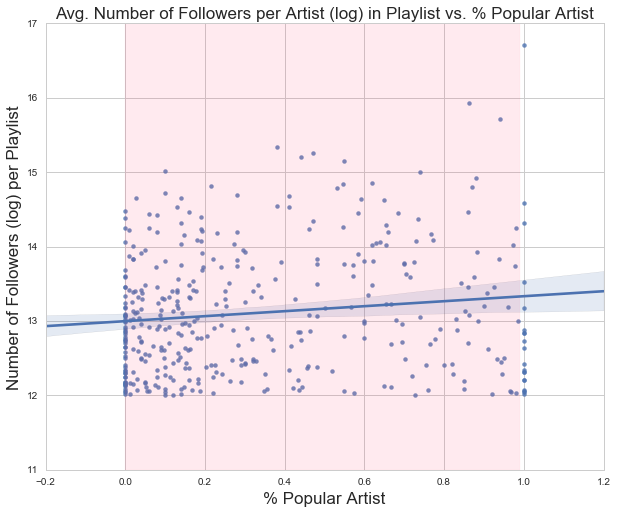

In [21]:
sns.set(style="whitegrid")
lower = np.percentile(top_sorted['popular_artist_pct'], 5)
upper = np.percentile(top_sorted['popular_artist_pct'], 95)
plt.figure(figsize = (10,8))
sns.regplot(np.asarray(top_sorted['popular_artist_pct']), np.asarray(log_followers_top))
plt.title('Avg. Number of Followers per Artist (log) in Playlist vs. % Popular Artist', size = 17)
plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.xlabel('% Popular Artist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

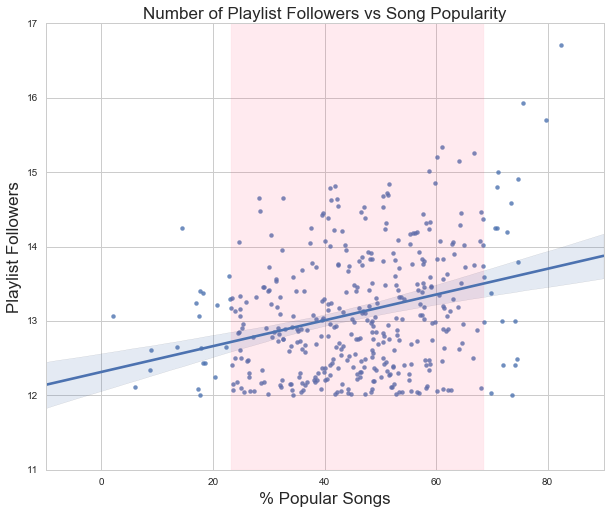

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize = (10,8))
lower = np.percentile(pop_top, 5)
upper = np.percentile(pop_top, 95)
sns.regplot(np.asarray(pop_top), np.asarray(log_followers_top))
plt.title('Number of Playlist Followers vs Song Popularity', size = 17)
plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.xlabel('% Popular Songs', size = 17)
plt.ylabel('Playlist Followers', size = 17)
plt.show()

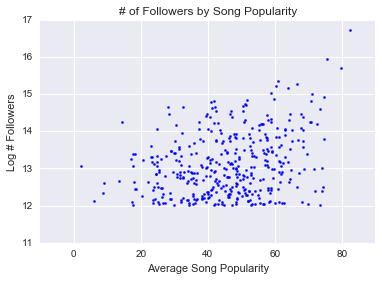

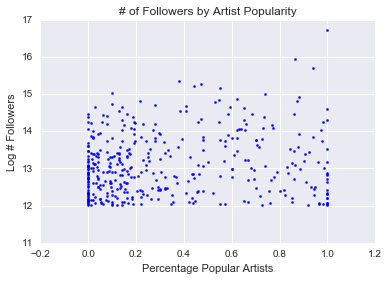

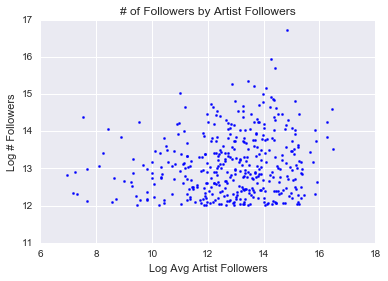

In [14]:
#top 3 of followers
top_quart = eda_frame['followers'].quantile(0.75)
top_frame = eda_frame.loc[eda_frame['followers'] >= top_quart]

top_sorted = top_frame.sort_values(by='log_followers')
log_followers_top = list(top_sorted['log_followers'])
followers_top = list(top_sorted['followers'])
pop_top = list(top_sorted['av_song_pop'])

plt.figure()
plt.scatter(pop_top, log_followers_top, marker = '.', color = 'b')
sns.despine(bottom=True, left=True)
plt.xlabel("Average Song Popularity");
plt.ylabel("Log # Followers")
plt.title("# of Followers by Song Popularity")

plt.figure()
plt.scatter(top_sorted['popular_artist_pct'], log_followers_top, marker = '.', color = 'b')
sns.despine(bottom=True, left=True)
plt.xlabel("Percentage Popular Artists");
plt.ylabel("Log # Followers")
plt.title("# of Followers by Artist Popularity")

plt.figure()
plt.scatter(top_sorted['log_artist_follow'], log_followers_top, marker = '.', color = 'b')
sns.despine(bottom=True, left=True)
plt.xlabel("Log Avg Artist Followers");
plt.ylabel("Log # Followers")
plt.title("# of Followers by Artist Followers");

In [136]:
eda_frame['1genre'] = np.where((eda_frame['pop_pct']>=.8)|(eda_frame['rap_pct']>=.8)|(eda_frame['rock_pct']>=.8), 1 , 0)
mixed_genre = eda_frame.loc[eda_frame['1genre'] == 0]
one_genre = eda_frame.loc[eda_frame['1genre'] == 1]

In [142]:
num_mixed = len(mixed_genre)
num_one = len(one_genre)
num_one

430

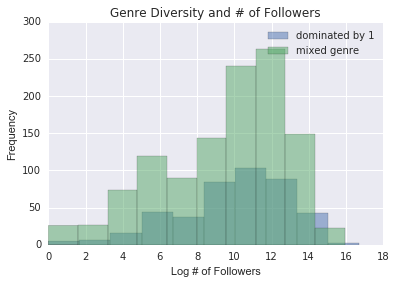

In [137]:
plt.hist(one_genre['log_followers'], alpha = 0.5, label='dominated by 1')
plt.hist(mixed_genre['log_followers'], alpha=0.5, label='mixed genre')
plt.legend(loc='upper right')
plt.title('Genre Diversity and # of Followers')
plt.ylabel('Frequency')
plt.xlabel('Log # of Followers')
plt.show()

In [23]:
top_quart

162876.75

In [24]:
eda_frame['followers'].quantile(0.8)

223847.80000000005